In [1]:
import psycopg2
import os

import numpy as np
import pandas as pd
import pandas.io.sql as sqlio

import flask
from flask import redirect, render_template, url_for, jsonify, request, send_file, abort

import random
import string

import shutil
import tempfile
import weakref

import timer3
import jsonpickle

import concurrent.futures
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import as_completed

import pm4py
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.conversion.dfg import converter as dfg_mining
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.visualization.petrinet import visualizer as pn_visualizer
from pm4py.statistics.traces.log import case_statistics
from pm4py.statistics.traces.log import case_arrival

In [2]:
db_host = os.getenv('POSTGRES_HOST')
db_port = os.getenv('POSTGRES_PORT')
db_name = os.getenv('POSTGRES_DB')
db_user = os.getenv('POSTGRES_USER')
db_pass = os.getenv('POSTGRES_PASSWORD')

In [3]:
class FileRemover(object):
    def __init__(self):
        self.weak_references = dict()  # weak_ref -> filepath to remove

    def cleanup_once_done(self, response, filepath):
        wr = weakref.ref(response, self._do_cleanup)
        self.weak_references[wr] = filepath

    def _do_cleanup(self, wr):
        filepath = self.weak_references[wr]
        print('Deleting %s' % filepath)
        shutil.rmtree(filepath, ignore_errors=True)

In [4]:
class ModeloEstatisticas:

    def __init__(self, qtde_casos, caso_dur_min, caso_dur_max, caso_dur_media, \
                 taxa_chegada_casos, taxa_dispersao_casos):
        self.qtde_casos = qtde_casos
        self.caso_dur_min = caso_dur_min
        self.caso_dur_max = caso_dur_max
        self.caso_dur_media = caso_dur_media
        self.taxa_chegada_casos = taxa_chegada_casos
        self.taxa_dispersao_casos = taxa_dispersao_casos

In [5]:
# Mapa chave=valor - ramo de justica/sufixo_tabela_fato
ramos_justica = {'Eleitoral': 'jele', 'Estadual': 'jest', 'Federal': 'jfed', 'Militar': 'jmil', 'Trabalho': 'jtra'}

In [6]:
# Cache para logs de evento
eventLogCache = {}

# Remove um log de eventos da cache pela chave
def clear_eventlog_cache(cacheKey):
    eventLog = eventLogCache.get(cacheKey)

    if eventLog is not None :
        eventLogCache[cacheKey] = None

In [7]:
# gera um log de eventos de acordo com os parametros informados.
def gerar_log_eventos(ramo_justica, codtribunal, atuacao, grau, codorgaoj, codnatureza, codclasse, dtinicio, dtfim, 
                      baixado = None, sensibility = '60'):
    
    eventLog = None

    cacheKey = "{0}-{1}-{2}-{3}-{4}-{5}-{6}-{7}-{8}-{9}".format(ramo_justica, codtribunal, atuacao, grau, codorgaoj, codnatureza, codclasse, dtinicio, dtfim, baixado)
    
    cachedEventLog = eventLogCache.get(cacheKey)
    if cachedEventLog is not None :
        eventLog = cachedEventLog

    else :
        conn = psycopg2.connect(host=db_host, port=db_port, database=db_name, user=db_user, password=db_pass)
        
        sufixo_ramo = ramos_justica.get(ramo_justica, 'default')
        
        tabela_fato = "inovacnj.fat_movimento_" + sufixo_ramo
        
        qry = "SELECT "
        qry+= "  fat.npu as npu, "
        qry+= "  CASE "
        qry+= "  WHEN f.descricao IS NULL THEN fat.mov_cod ||  ' - ' || mov.descricao "
        qry+= "  ELSE f.descricao || ': ' || fat.mov_cod ||  ' - ' || mov.descricao "
        qry+= "  END AS atividade, "
        qry+= "  fat.mov_dtmov as mov_dtmov "
        qry+= "FROM " + tabela_fato + " fat "
        qry+= "INNER JOIN inovacnj.acervo_processo_" + sufixo_ramo + " ap ON ap.npu = fat.npu "
        qry+= "INNER JOIN inovacnj.orgao_julgador oj ON oj.cod = fat.oj_cod::integer "
        qry+= "INNER JOIN inovacnj.movimentocnj mov ON mov.cod = fat.mov_cod "
        qry+= "INNER JOIN inovacnj.natureza_classe nc ON nc.cod_classe = fat.codclasse "
        qry+= "INNER JOIN inovacnj.natureza nat ON nat.cod = nc.cod_natureza "
        qry+= "LEFT JOIN inovacnj.fase_movimento fm ON fm.cod_movimento = fat.mov_cod "
        qry+= "LEFT JOIN inovacnj.fase f ON f.cod = fm.cod_fase "
        qry+= "WHERE (1=1) "
        
        if baixado is not None :
            qry+= "AND ap.baixado = '" + baixado + "' "
        if codtribunal is not None :
            qry+= "AND fat.codtribunal = '" + codtribunal + "' "
        if atuacao is not None :
            qry+= "AND oj.atuacao_vara = '" + atuacao + "' "
        if codorgaoj is not None :
            qry+= "AND fat.oj_cod = '" + codorgaoj + "' "
        if grau is not None :
            qry+= "AND fat.grau = '" + grau + "' "
        if codnatureza is not None :
            qry+= "AND nat.cod = " + str(codnatureza) + " "
        if codclasse is not None :
            qry+= "AND fat.codclasse = " + str(codclasse) + " "
            
        if dtinicio is not None and dtfim is not None:
            qry+= "AND fat.mov_dtmov BETWEEN to_timestamp('" + dtinicio + "', 'yyyy-MM-dd') AND to_timestamp('" + dtfim + "', 'yyyy-MM-dd') "
            
        qry+= "ORDER BY fat.npu, fat.mov_dtmov ASC "
        
        print(qry)
        
        df_logeventos_pd = pd.read_sql_query(qry, conn)
        
        if df_logeventos_pd.empty == False :
            df_event_log = pm4py.format_dataframe(df_logeventos_pd, case_id='npu', activity_key='atividade', timestamp_key='mov_dtmov')
            eventLog = pm4py.convert_to_event_log(df_event_log)

            eventLogCache[cacheKey] = eventLog
            timer3.apply_after(1000 * 60 * 15, clear_eventlog_cache, args=([cacheKey]), priority=0)

    if eventLog is not None :
        if sensibility is not None :
            eventLog = pm4py.filter_variants_percentage(eventLog, percentage=float(sensibility) / 100)

    return eventLog

In [8]:
# Gera o DFG Model a partir do log de eventos
def gerar_dfg_model_from_log_eventos(eventLog):
    if eventLog != None :
        #Create dfg model from log
        return dfg_discovery.apply(eventLog)
    else :
        return None

In [9]:
# Gera a visualização do modelo
def gerar_view_dfg_model(eventLog, dfg, metric_type = 'FREQUENCY', image_format = 'png'):
    gviz = None
    
    if metric_type == 'PERFORMANCE' :
        parameters = {dfg_visualization.Variants.PERFORMANCE.value.Parameters.FORMAT: image_format}
        # Visualise
        gviz = dfg_visualization.apply(dfg, log=eventLog, variant=dfg_visualization.Variants.PERFORMANCE, parameters=parameters)
    elif metric_type == 'FREQUENCY' :
        parameters = {dfg_visualization.Variants.FREQUENCY.value.Parameters.FORMAT: image_format}
        # Visualise
        gviz = dfg_visualization.apply(dfg, log=eventLog, variant=dfg_visualization.Variants.FREQUENCY, parameters=parameters)
    else :
        print("Invalid metric_type: " + metric_type)

    return gviz

In [10]:
# Gera a visualização do modelo com base nos parametros
def gerar_view_dfg_model_from_params(ramo_justica, codtribunal, atuacao, grau, codorgaoj, codnatureza, codclasse, 
                                     dtinicio, dtfim, baixado = None, sensibility = '60', metric_type = 'FREQUENCY', image_format = 'png'):
    
    gviz = None
    
    eventLog = gerar_log_eventos(ramo_justica, codtribunal, atuacao, grau, codorgaoj, codnatureza, codclasse, dtinicio, dtfim, baixado, sensibility)
    
    if eventLog is not None :
        dfg = gerar_dfg_model_from_log_eventos(eventLog)
        gviz = gerar_view_dfg_model(eventLog, dfg, metric_type, image_format)
    
    return gviz

In [11]:
# Gera as estatisticas do modelo
def gerar_estatisticas_model_from_log_eventos(eventLog):

    parameters_stats = {
        case_statistics.Parameters.TIMESTAMP_KEY: "time:timestamp"
    }
    
    # (quantidade de casos no event log)
    all_case_durations = case_statistics.get_all_casedurations(eventLog, parameters=parameters_stats)
    # (duração do caso mais rápido)
    min_case_duration = min(all_case_durations)
    # (duração do caso mais demorado)
    max_case_duration = max(all_case_durations)
    # (média de duração dos casos)
    median_case_duration = case_statistics.get_median_caseduration(eventLog, parameters=parameters_stats)
    
    parameters_arrival = {
        case_arrival.Parameters.TIMESTAMP_KEY: "time:timestamp"
    }

    # (distância média entre a chegada de dois casos consecutivos)
    case_arrival_ratio = case_arrival.get_case_arrival_avg(eventLog, parameters=parameters_arrival)
    # (distância média entre a finalização de dois casos consecutivos)
    case_dispersion_ratio = case_arrival.get_case_dispersion_avg(eventLog, parameters=parameters_arrival)
    
    return ModeloEstatisticas(qtde_casos=len(all_case_durations), caso_dur_min=min_case_duration, caso_dur_max=max_case_duration, \
        caso_dur_media=median_case_duration, taxa_chegada_casos=case_arrival_ratio, taxa_dispersao_casos=case_dispersion_ratio)


In [12]:
# Gera as estatisticas do modelo com base nos parametros
def gerar_estatistica_model_from_params(ramo_justica, codtribunal, atuacao, grau, codorgaoj, codnatureza, codclasse, 
                                     dtinicio, dtfim, baixado = None, sensibility = '60'):
    
    est_model = None
    
    eventLog = gerar_log_eventos(ramo_justica, codtribunal, atuacao, grau, codorgaoj, codnatureza, codclasse, dtinicio, dtfim, baixado, sensibility)
    
    if eventLog is not None :
        est_model = gerar_estatisticas_model_from_log_eventos(eventLog)
    
    return est_model

In [13]:
# consulta os orgaos julgadores por tribunal e atuacao da vara
def consultar_orgaosjulgadores_por_tribunal_e_atuacaovara(codtribunal, atuacao):
    
    conn = psycopg2.connect(host=db_host, port=db_port, database=db_name, user=db_user, password=db_pass)

    qry = "SELECT "
    qry+= "  cod, "
    qry+= "  descricao "
    qry+= "FROM inovacnj.orgao_julgador oj "
    qry+= "WHERE (1=1) "

    if codtribunal is not None :
        qry+= "AND oj.codtribunal = '" + codtribunal + "' "
    if atuacao is not None :
        qry+= "AND oj.atuacao_vara = '" + atuacao + "' "

    qry+= "ORDER BY descricao ASC"
    
    df = pd.read_sql_query(qry, conn)
    
    return df

In [14]:
# executa um token replay em um log de eventos
def get_token_replayed_traces_from_params(net, initial_marking, final_marking,
                             ramo_justica, codtribunal, atuacao, grau, codorgaoj, codnatureza, codclasse, 
                             dtinicio, dtfim, baixado = None, sensibility = '60'):
    print("token_replayed_traces para {0}-{1}-{2}-{3}-{4}-{5}-{6}-{7}-{8}-{9}".format(ramo_justica, codtribunal, atuacao, grau, codorgaoj, codnatureza, codclasse, dtinicio, dtfim, baixado))
    
    eventLog_oj = gerar_log_eventos(ramo_justica, codtribunal, atuacao, grau, codorgaoj, codnatureza, codclasse, dtinicio, dtfim, baixado, sensibility)
    replayed_traces = token_replay.apply(eventLog_oj, net, initial_marking, final_marking)
   
    return replayed_traces

In [20]:
# Gera as lista de orgao julgadores com o percentual de compatibilidade com o modelo
def gerar_orgaosjulgadores_modelfit_from_params(ramo_justica, codtribunal, atuacao, grau, codorgaoj, codnatureza, codclasse, 
                                     dtinicio, dtfim, baixado = None, sensibility = '60'):
    print("gerar_orgaosjulgadores_modelfit_from_params")
    eventLog = gerar_log_eventos(ramo_justica, codtribunal, atuacao, grau, codorgaoj, codnatureza, codclasse, 
                                 dtinicio, dtfim, baixado, sensibility)
    net, initial_marking, final_marking = alpha_miner.apply(eventLog)
    
    orgaos_model_fit = []
    
    df = consultar_orgaosjulgadores_por_tribunal_e_atuacaovara(codtribunal, atuacao)
    
    with ThreadPoolExecutor(max_workers = 15) as executor:
        
        future_to_row = {executor.submit(
                            get_token_replayed_traces_from_params, 
                            net, initial_marking, final_marking,
                             ramo_justica, codtribunal, atuacao, grau, str(row["cod"]), codnatureza, codclasse, 
                             dtinicio, dtfim, baixado, sensibility): row for index, row in df.iterrows()}
        for future in concurrent.futures.as_completed(future_to_row):
            row = future_to_row[future]
            try:
                replayed_traces = future.result()
                orgao_model_fit = {
                  "cod": row["cod"],
                  "descricao": row["descricao"],
                  "traceFitness": str(replayed_traces[0]['trace_fitness'] * 100) + ' %',
                  "traceIsFit": replayed_traces[0]['trace_is_fit']
                }
                orgaos_model_fit.append(orgao_model_fit)
            except Exception as exc:
                print('%r generated an exception: %s' % (row, exc))
    
    sorted_orgaos_model_fit = sorted(orgaos_model_fit, key = lambda i: i['traceFitness'], reverse=True)
    
    return sorted_orgaos_model_fit

SELECT   fat.npu as npu,   CASE   WHEN f.descricao IS NULL THEN fat.mov_cod ||  ' - ' || mov.descricao   ELSE f.descricao || ': ' || fat.mov_cod ||  ' - ' || mov.descricao   END AS atividade,   fat.mov_dtmov as mov_dtmov FROM inovacnj.fat_movimento_jest fat INNER JOIN inovacnj.acervo_processo_jest ap ON ap.npu = fat.npu INNER JOIN inovacnj.orgao_julgador oj ON oj.cod = fat.oj_cod::integer INNER JOIN inovacnj.movimentocnj mov ON mov.cod = fat.mov_cod INNER JOIN inovacnj.natureza_classe nc ON nc.cod_classe = fat.codclasse INNER JOIN inovacnj.natureza nat ON nat.cod = nc.cod_natureza LEFT JOIN inovacnj.fase_movimento fm ON fm.cod_movimento = fat.mov_cod LEFT JOIN inovacnj.fase f ON f.cod = fm.cod_fase WHERE (1=1) AND fat.codtribunal = 'TJPE' AND oj.atuacao_vara = 'Cível' ORDER BY fat.npu, fat.mov_dtmov ASC 


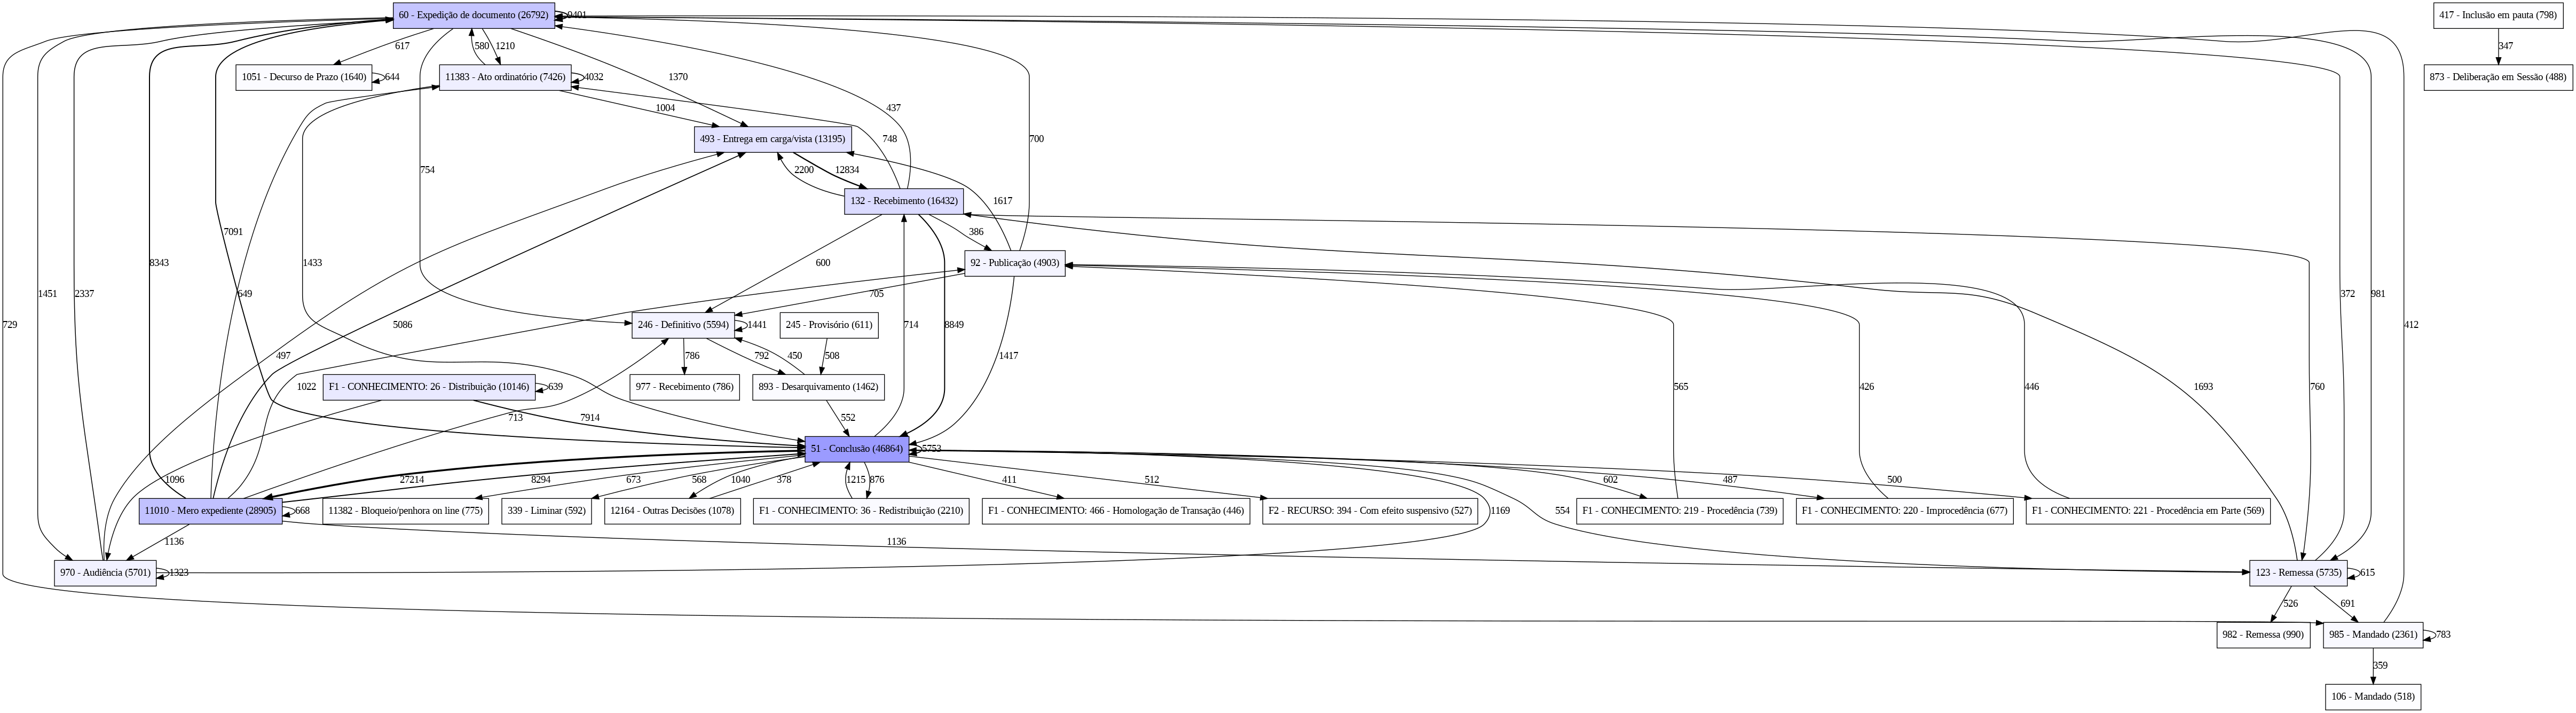

In [16]:
eventLog = gerar_log_eventos('Estadual', 'TJPE', 'Cível', None, None, None, None, None, None, None, '65')
if eventLog != None :
    dfg = gerar_dfg_model_from_log_eventos(eventLog)
    gviz = gerar_view_dfg_model(eventLog, dfg, metric_type = 'FREQUENCY')
    dfg_visualization.view(gviz)

In [22]:
models_fit = gerar_orgaosjulgadores_modelfit_from_params('Estadual', 'TJPE', 'Cível', None, None, None, None, None, None, None, '65')
print(models_fit)

gerar_orgaosjulgadores_modelfit_from_params
token_replayed_traces para Estadual-TJPE-Cível-None-18024-None-None-None-None-None
token_replayed_traces para Estadual-TJPE-Cível-None-18025-None-None-None-None-None
token_replayed_traces para Estadual-TJPE-Cível-None-17384-None-None-None-None-None
token_replayed_traces para Estadual-TJPE-Cível-None-17385-None-None-None-None-None
token_replayed_traces para Estadual-TJPE-Cível-None-18030-None-None-None-None-None
token_replayed_traces para Estadual-TJPE-Cível-None-17387-None-None-None-None-None
token_replayed_traces para Estadual-TJPE-Cível-None-17388-None-None-None-None-None
token_replayed_traces para Estadual-TJPE-Cível-None-18034-None-None-None-None-None
token_replayed_traces para Estadual-TJPE-Cível-None-18035-None-None-None-None-Nonetoken_replayed_traces para Estadual-TJPE-Cível-None-17389-None-None-None-None-None
token_replayed_traces para Estadual-TJPE-Cível-None-17390-None-None-None-None-None
token_replayed_traces para Estadual-TJPE-Cív

token_replayed_traces para Estadual-TJPE-Cível-None-17407-None-None-None-None-None
token_replayed_traces para Estadual-TJPE-Cível-None-6659-None-None-None-None-None
token_replayed_traces para Estadual-TJPE-Cível-None-17408-None-None-None-None-None
token_replayed_traces para Estadual-TJPE-Cível-None-17410-None-None-None-None-None
token_replayed_traces para Estadual-TJPE-Cível-None-70619-None-None-None-None-None
token_replayed_traces para Estadual-TJPE-Cível-None-70620-None-None-None-None-None
token_replayed_traces para Estadual-TJPE-Cível-None-70622-None-None-None-None-None
token_replayed_traces para Estadual-TJPE-Cível-None-70628-None-None-None-None-None
token_replayed_traces para Estadual-TJPE-Cível-None-70636-None-None-None-None-Nonetoken_replayed_traces para Estadual-TJPE-Cível-None-70641-None-None-None-None-None

token_replayed_traces para Estadual-TJPE-Cível-None-70642-None-None-None-None-None
token_replayed_traces para Estadual-TJPE-Cível-None-70643-None-None-None-None-None
token

In [18]:
#import svgutils.transform as sg
#from IPython.display import SVG,display

#gviz = gerar_modelo_pm_from_params('TJPE', None, '7628', 'CIVEL', 7, None, None, 0.4, tipometrica = 'FREQUENCY', imageformat = 'svg')
#if gviz != None:
#    #dfg_visualization.view(gviz)
#    dfg_visualization.save(gviz, 'dfg.svg')
#    
#    display(SVG(filename='dfg.svg'))
#
#else:
#    print("sem dados")

In [19]:
app = flask.Flask(__name__)

@app.route('/api/v1/tipo-justica')
def api_lista_tipojustica():
    conn = psycopg2.connect(host=db_host, port=db_port, database=db_name, user=db_user, password=db_pass)
    cur = conn.cursor()
    
    qry = "SELECT DISTINCT tipo as cod, tipo as descricao "
    qry+= "FROM inovacnj.tribunal"
    
    cur.execute(qry)
    lista = cur.fetchall()

    return jsonify(lista)

@app.route('/api/v1/porte')
def api_lista_porte():
    conn = psycopg2.connect(host=db_host, port=db_port, database=db_name, user=db_user, password=db_pass)
    cur = conn.cursor()
    
    qry = "SELECT DISTINCT porte as cod, porte as descricao "
    qry+= "FROM inovacnj.tribunal"
    
    cur.execute(qry)
    lista = cur.fetchall()

    return jsonify(lista)

@app.route('/api/v1/tribunal')
def api_lista_tribunal():
    porte = request.args.get('porte')
    tipo = request.args.get('tipo')
    conn = psycopg2.connect(host=db_host, port=db_port, database=db_name, user=db_user, password=db_pass)
    cur = conn.cursor()
    
    qry = "SELECT cod, descricao, sigla, tipo, porte "
    qry+= "FROM inovacnj.tribunal "
    qry+= "WHERE (1=1) "
    if porte != None :
        qry+= "AND porte = '" + porte + "' "
    if tipo != None :
        qry+= "AND tipo = '" + tipo + "' "
    
    cur.execute(qry)
    lista = cur.fetchall()

    return jsonify(lista)

@app.route('/api/v1/orgao-julgador', methods=['GET'])
def get_orgaosJulgadores():
    codtribunal = request.args.get('codtribunal')
    conn = psycopg2.connect(host=db_host, port=db_port, database=db_name, user=db_user, password=db_pass)
    cur = conn.cursor()

    qry = "SELECT cod, descricao, tipo_oj, codtribunal "
    qry+= "FROM inovacnj.orgao_julgador "
    qry+= "WHERE (1=1) "
    
    if codtribunal != None :
        qry+= "AND codtribunal = '" + codtribunal + "' "
    qry+= "ORDER BY ordem NULLS LAST "
    print(qry)
    cur.execute(qry)
    lista = cur.fetchall()
    return jsonify(lista)

@app.route('/api/v1/natureza')
def api_lista_natureza():
    conn = psycopg2.connect(host=db_host, port=db_port, database=db_name, user=db_user, password=db_pass)
    cur = conn.cursor()
    
    qry = "SELECT distinct natureza as codnatureza, natureza as descricao "
    qry+= "FROM inovacnj.movimentocnj "
    qry+= "WHERE natureza IS NOT NULL "
    
    cur.execute(qry)
    lista = cur.fetchall()

    return jsonify(lista)

@app.route('/api/v1/classe')
def api_lista_classe():
    natureza = request.args.get('natureza')
    conn = psycopg2.connect(host=db_host, port=db_port, database=db_name, user=db_user, password=db_pass)
    cur = conn.cursor()
    
    qry = "SELECT cod, descricao, sigla, codpai "
    qry+= "FROM inovacnj.classe "
    qry+= "WHERE (1=1)"
    
    cur.execute(qry)
    lista = cur.fetchall()

    return jsonify(lista)

@app.route('/api/v1/movimento')
def api_lista_movimento():
    natureza = request.args.get('natureza')
    conn = psycopg2.connect(host=db_host, port=db_port, database=db_name, user=db_user, password=db_pass)
    cur = conn.cursor()
      
    qry = "SELECT cod, descricao, natureza, fase, codpai "
    qry+= "FROM inovacnj.movimentocnj "
    qry+= "WHERE (1=1)"
    if natureza != None :
        qry+= "AND natureza = '" + natureza + "' "
    
    cur.execute(qry)
    lista = cur.fetchall()

    return jsonify(lista)

@app.route('/api/v1/assuntos-ranking')
def api_lista_assuntos_ranking():
    tipo = request.args.get('tipo')
    codtribunal = request.args.get('codtribunal')
    codorgaoj = request.args.get('codorgaoj')
    natureza = request.args.get('natureza')
    codclasse = request.args.get('codclasse')
    
    conn = psycopg2.connect(host=db_host, port=db_port, database=db_name, user=db_user, password=db_pass)
    cur = conn.cursor()
      
    qry = "SELECT descassunto as assunto, count(distinct npu) as quantidade "
    qry+= "FROM inovacnj.fat_movimentos_te, inovacnj.tribunal "
    qry+= "WHERE (1=1) "
    qry+= "AND fat_movimentos_te.codtribunal = tribunal.cod "
    if tipo != None :
        qry+= "AND tribunal.tipo = '" + tipo + "' "
    if codtribunal != None :
        qry+= "AND tribunal.cod = '" + codtribunal + "' "
    if codorgaoj != None :
        qry+= "AND fat_movimentos_te.oj_cod = '" + codorgaoj + "' "
    if natureza != None :
        qry+= "AND fat_movimentos_te.natureza = '" + natureza + "' "
    if codclasse != None :
        qry+= "AND fat_movimentos_te.codclasse = '" + codclasse + "' "
        
    qry+= "GROUP BY descassunto "
    qry+= "ORDER BY quantidade desc "
    
    cur.execute(qry)
    lista = cur.fetchall()

    return jsonify(lista)


@app.route('/api/v1/gerar-modelo-pm')
def api_gerar_modelo_pm():
    ramojustica = request.args.get('ramojustica')
    codtribunal = request.args.get('codtribunal')
    atuacao = request.args.get('atuacao')
    grau = request.args.get('grau')
    codorgaoj = request.args.get('codorgaoj')
    natureza = request.args.get('natureza')
    codclasse = request.args.get('codclasse')
    dtinicio = request.args.get('dtinicio')
    dtfim = request.args.get('dtfim')
    baixado = request.args.get('baixado')
    sensibilidade = request.args.get('sensibilidade')
    metrica = request.args.get('metrica')
    formato = request.args.get('formato')
    
    if ramojustica is None:
        abort(400, description="ramojustica nao informado")
    if codtribunal is None:
        abort(400, description="codtribunal nao informado")
    
    gviz = gerar_view_dfg_model_from_params(ramojustica, codtribunal, atuacao, grau, codorgaoj, natureza, codclasse,
                                            dtinicio, dtfim, baixado, sensibilidade, metrica, formato)
    if gviz != None:
        file_remover = FileRemover()
        tempdir = tempfile.mkdtemp()
        path = tempdir + "/model_mp." + str(formato).lower()
        dfg_visualization.save(gviz, path)
        resp = send_file(path, as_attachment=False)
        file_remover.cleanup_once_done(resp, path)
        return resp
    else:
        print("sem dados")
        abort(404, description="Nao encontrado")
        
@app.route('/api/v1/gerar-estatisticas-modelo-pm')
def api_gerar_estatisticas_modelo_pm():
    ramojustica = request.args.get('ramojustica')
    codtribunal = request.args.get('codtribunal')
    atuacao = request.args.get('atuacao')
    grau = request.args.get('grau')
    codorgaoj = request.args.get('codorgaoj')
    natureza = request.args.get('natureza')
    codclasse = request.args.get('codclasse')
    dtinicio = request.args.get('dtinicio')
    dtfim = request.args.get('dtfim')
    baixado = request.args.get('baixado')
    sensibilidade = request.args.get('sensibilidade')
    
    if ramojustica is None:
        abort(400, description="ramojustica nao informado")
    if codtribunal is None:
        abort(400, description="codtribunal nao informado")
    
    estat = gerar_estatistica_model_from_params(ramojustica, codtribunal, atuacao, grau, codorgaoj, natureza, codclasse,
                                                dtinicio, dtfim, baixado, sensibilidade)
    if estat is not None:
        return jsonpickle.encode(estat)
    else:
        print("sem dados")
        abort(404, description="Nao encontrado")
              
@app.route('/api/v1/gerar-orgaosjulgadores-modelfit')
def api_gerar_orgaosjulgadores_modelfit():
    ramojustica = request.args.get('ramojustica')
    codtribunal = request.args.get('codtribunal')
    atuacao = request.args.get('atuacao')
    grau = request.args.get('grau')
    codorgaoj = request.args.get('codorgaoj')
    natureza = request.args.get('natureza')
    codclasse = request.args.get('codclasse')
    dtinicio = request.args.get('dtinicio')
    dtfim = request.args.get('dtfim')
    baixado = request.args.get('baixado')
    sensibilidade = request.args.get('sensibilidade')
    
    if ramojustica is None:
        abort(400, description="ramojustica nao informado")
    if codtribunal is None:
        abort(400, description="codtribunal nao informado")
    if atuacao is None:
        abort(400, description="atuacao nao informado")
    
    modelfit = gerar_orgaosjulgadores_modelfit_from_params(ramojustica, codtribunal, atuacao, grau, codorgaoj, natureza, codclasse, 
                                                           dtinicio, dtfim, baixado, sensibilidade)
    if modelfit is not None:
        return jsonpickle.encode(modelfit)
    else:
        print("sem dados")
        abort(404, description="Nao encontrado")
    
    

app.run(host='0.0.0.0', port='8080')

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:8080/ (Press CTRL+C to quit)
